 # xG Model with Hyperparameter Optimization and Feature Contributions
 
This notebook provides a clean, organized workflow: data loading, feature engineering,
hyperparameter optimization for XGBoost, final training, and analysis of feature contributions
(including 'rivals_in_shot_area').

### 1. Import libraries

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from shapely.geometry import Point, Polygon
from scipy.stats import randint, uniform
import ast
import shap

### 2. Helper functions for feature engineering

In [10]:
def parse_if_str(x):
    """If x is a string with Python/JSON syntax, convert to native object."""
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x


def safe_point_coords(loc):
    """Ensure loc is [x, y] with floats. Parse if string and cast to float."""
    loc = parse_if_str(loc)
    try:
        return [float(loc[0]), float(loc[1])]
    except Exception:
        return None


def count_players(jugadores, v1):
    """Count opponents within the triangular shot area defined by v1, (120,36), (120,44)."""
    if not isinstance(jugadores, (list, str)):
        return 0
    jugadores = parse_if_str(jugadores)
    if not isinstance(jugadores, list):
        return 0
    v1_coords = safe_point_coords(v1)
    if v1_coords is None:
        return 0
    v2, v3 = [120.0,36.0], [120.0,44.0]
    poly = Polygon([v1_coords, v2, v3])
    count = 0
    for p in jugadores:
        loc = p.get('location', None)
        loc_coords = safe_point_coords(loc)
        if loc_coords is None:
            continue
        pt = Point(*loc_coords)
        if pt.within(poly) or pt.touches(poly):
            count += 1
    return count

def keeper_position_score(jugadores, v1):
    jugadores = parse_if_str(jugadores)
    if not isinstance(jugadores, list):
        return 0.0

    keeper = None
    for p in jugadores:
        if p.get('position',{}).get('name','') == 'Goalkeeper':
            keeper = p
            break
    if keeper is None:
        return 0.0

    v1 = safe_point_coords(v1)
    if v1 is None:
        return 0.0
    v2, v3 = [120.0, 36.0], [120.0, 44.0]
    tri = Polygon([v1, v2, v3])

    kp = safe_point_coords(keeper['location'])
    if kp is None:
        return 0.0

    pt_kp = Point(*kp)
    if not (pt_kp.within(tri) or pt_kp.touches(tri)):
        return 0.0

    C = [(v2[0]+v3[0])/2, (v2[1]+v3[1])/2]  # [120,40]
    A = np.array(v1)
    B = np.array(C)
    P = np.array(kp)
    # d_perp = || ( (P-A) × (B-A) ) || / ||B-A||
    BA = B - A
    PA = P - A
    cross = abs(BA[0]*PA[1] - BA[1]*PA[0])
    d_perp = cross / np.linalg.norm(BA)

    b = (v3[1] - v2[1]) / 2.0
    score = 1 - (d_perp / b)
    return float(max(0.0, min(1.0, score)))

### 3. Load data and define target

In [11]:
df = pd.read_csv("../output/csv/all_shots.csv")
GOAL_ID = 97  # Adjust according to dataset
# Create binary target: 1 = goal, 0 = no goal
df['is_goal'] = (df['shot_outcome_id'] == GOAL_ID).astype(int)

### 4. Main feature engineering

In [12]:
# Create squared and interaction features for distance and angle
df['distance_to_goal_squared'] = df['distance_to_goal'] ** 2
df['angle_to_goal_squared']    = df['angle_to_goal'] ** 2

df['distance_angle_interaction'] = df['distance_to_goal'] * df['angle_to_goal']

# Create buckets for possession duration and key pass attributes
df['possession_bucket'] = pd.cut(df['possession_duration'], bins=[0,5,15,1000],
                                  labels=['Counterattack','Short Attack','Long Attack']).astype(str)

df['key_pass_length_bucket'] = pd.cut(df['key_pass_length'], bins=[0,10,30,1000],
                                       labels=['Short','Medium','Long']).astype(str)

df['key_pass_angle_bucket'] = pd.cut(df['key_pass_angle'], bins=[-3.15,-1,1,3.15],
                                      labels=['Left','Forward','Right']).astype(str)

# Calculate number of rival players in the shot area (can take a few seconds)
print("Calculating rivals in shot area, this may take a few seconds...")
df['rivals_in_shot_area'] = df.apply(
    lambda row: count_players(row['shot_freeze_frame'], row['location']), axis=1
)

df['keeper_placement_score'] = df.apply(
    lambda row: keeper_position_score(row['shot_freeze_frame'],row['location']),axis=1
    )

# Binary flag: has key pass
df['has_key_pass'] = df['key_pass_length'].notnull().astype(int)

# Drop any rows without a target value
df = df.dropna(subset=['is_goal'])


Calculating rivals in shot area, this may take a few seconds...


### 5. Define columns for the pipeline

In [24]:
numerical_cols = [
    'distance_to_goal', 'angle_to_goal', 'possession_duration',
    'key_pass_length', 'key_pass_angle', 'rivals_in_shot_area',
    'distance_to_goal_squared', 'angle_to_goal_squared', 'distance_angle_interaction',
    'keeper_placement_score'
]
categorical_cols = [
    'play_pattern_id', 'shot_body_part_id', 'shot_technique_id',
    'shot_type_id', 'key_pass_height_id', 'key_pass_body_part_id',
    'under_pressure', 'shot_first_time', 'shot_aerial_won',
    'key_pass_switch', 'key_under_pressure', 'key_pass_cross', 'key_pass_cut_back',
    'possession_bucket', 'key_pass_length_bucket', 'key_pass_angle_bucket'
]

# Preprocessors
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

### 6. Data splitting

In [27]:
X = df[numerical_cols + categorical_cols]
y = df['is_goal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

preprocessor.fit(X_train)

# Extrae los nombres
feat_names = preprocessor.get_feature_names_out()
print(f"Total features tras preprocesar: {len(feat_names)}")
print(feat_names)

Total features tras preprocesar: 71
['num__distance_to_goal' 'num__angle_to_goal' 'num__possession_duration'
 'num__key_pass_length' 'num__key_pass_angle' 'num__rivals_in_shot_area'
 'num__distance_to_goal_squared' 'num__angle_to_goal_squared'
 'num__distance_angle_interaction' 'num__keeper_placement_score'
 'cat__play_pattern_id_1' 'cat__play_pattern_id_2'
 'cat__play_pattern_id_3' 'cat__play_pattern_id_4'
 'cat__play_pattern_id_5' 'cat__play_pattern_id_6'
 'cat__play_pattern_id_7' 'cat__play_pattern_id_8'
 'cat__play_pattern_id_9' 'cat__shot_body_part_id_37.0'
 'cat__shot_body_part_id_38.0' 'cat__shot_body_part_id_40.0'
 'cat__shot_body_part_id_70.0' 'cat__shot_technique_id_89.0'
 'cat__shot_technique_id_90.0' 'cat__shot_technique_id_91.0'
 'cat__shot_technique_id_92.0' 'cat__shot_technique_id_93.0'
 'cat__shot_technique_id_94.0' 'cat__shot_technique_id_95.0'
 'cat__shot_type_id_61.0' 'cat__shot_type_id_62.0'
 'cat__shot_type_id_65.0' 'cat__shot_type_id_87.0'
 'cat__shot_type_id_88.0

### 7. Hyperparameter search with RandomizedSearchCV

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
param_dist = {
    'classifier__n_estimators': randint(600, 1500),
    'classifier__learning_rate': uniform(0.01, 0.08),
    'classifier__max_depth': randint(3, 8),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': uniform(0, 5),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(0, 2),
}

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# CV and search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc',
    cv=cv,
    verbose=3,
    n_jobs=-1,
    random_state=0,
    refit=True,
    return_train_score=True,
    error_score=0.0
)

search.fit(X_train, y_train)
print("Best parameters:", search.best_params_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Results
print("\nBest AUC in CV:", search.best_score_)

# Final evaluation
best_model = search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Test AUC: {auc:.4f}")

Antes de preprocesar: ['distance_to_goal', 'angle_to_goal', 'possession_duration', 'key_pass_length', 'key_pass_angle', 'rivals_in_shot_area', 'distance_to_goal_squared', 'angle_to_goal_squared', 'distance_angle_interaction', 'keeper_placement_score', 'play_pattern_id', 'shot_body_part_id', 'shot_technique_id', 'shot_type_id', 'key_pass_height_id', 'key_pass_body_part_id', 'under_pressure', 'shot_first_time', 'shot_aerial_won', 'key_pass_switch', 'key_under_pressure', 'key_pass_cross', 'key_pass_cut_back', 'possession_bucket', 'key_pass_length_bucket', 'key_pass_angle_bucket']
Shape tras preprocesar: (51215, 71)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

### 8. Train final model with best parameters

In [21]:
final_pipeline = search.best_estimator_
final_pipeline.fit(X_train, y_train)

c:\Users\rgbej\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 9. Evaluation on test set

In [22]:
y_pred_prob = final_pipeline.predict_proba(X_test)[:,1]
# Override penalty shots with constant xG
PENALTY_ID = 88
penalty_mask = (X_test['shot_type_id'] == PENALTY_ID)
y_pred_prob[penalty_mask] = 0.75
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Final AUC: {auc:.4f}")

Final AUC: 0.8227


### 10. Feature importances and SHAP analysis

Top 10 XGBoost feature importances:
num__rivals_in_shot_area           78.185318
num__distance_to_goal              55.385925
num__distance_to_goal_squared      40.600906
cat__shot_body_part_id_37.0        38.814301
cat__shot_aerial_won_False         30.399969
cat__key_pass_height_id_1.0        26.207796
cat__shot_aerial_won_True          24.858734
num__keeper_placement_score        20.698584
cat__key_pass_height_id_3.0        19.902857
num__distance_angle_interaction    19.047121
dtype: float64


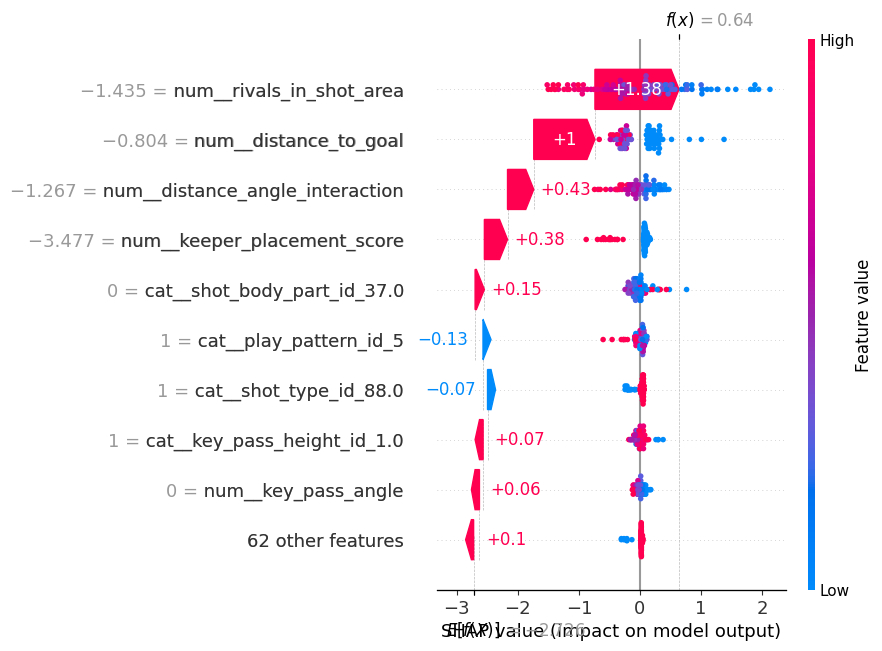

In [23]:
# Retrieve feature names after preprocessing
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# XGBoost gain-based importances
gain_scores = final_pipeline.named_steps['classifier'].get_booster().get_score(
    importance_type='gain'
)
importances = pd.Series(gain_scores)
# Map f-indexes to actual feature names
importances.index = [feature_names[int(f[1:])] for f in importances.index]
importances = importances.sort_values(ascending=False)
print("Top 10 XGBoost feature importances:")
print(importances.head(10))

# SHAP analysis
# Sample a subset for SHAP to reduce computation time
df_sample = X_test.sample(100, random_state=0)
# Transform features using the preprocessing pipeline
X_transformed = final_pipeline.named_steps['preprocessor'].transform(df_sample)
# Use TreeExplainer on the trained XGBoost model, passing preprocessed data as background
explainer = shap.TreeExplainer(final_pipeline.named_steps['classifier'], X_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_transformed)

# Plot summary bar with actual feature names
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, max_display=10, show=False)
# Plot waterfall for the first sample
shap.plots.waterfall(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_transformed[0], feature_names=feature_names))

